# Stage Three: Unsupervised Techniques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from nltk.tokenize import word_tokenize
import textstat

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
import utilities as ut


In [4]:
training_path = '../data/WikiLarge_Train.csv'

In [5]:
%%time
df = ut.produce_dataframe(training_path)
df.head()

CPU times: user 54.6 s, sys: 419 ms, total: 55 s
Wall time: 55.1 s


,original_text,label,tokens,sentence_length
0,There is manuscript evidence that Austen conti...,1,"[there, is, manuscript, evidence, that, austen...",43
1,"In a remarkable comparative analysis , Mandaea...",1,"[in, a, remarkable, comparative, analysis, ,, ...",23
2,"Before Persephone was released to Hermes , who...",1,"[before, persephone, was, released, to, hermes...",46
3,Cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",39
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"[geneva, -lrb-, ,, ;, ,, ;, ,, ;, ;, -rrb-, is...",36


In [6]:
df.shape

(416768, 4)

In [7]:
# for development purposes
df_x = df.sample(frac=1, random_state=42)
df_x.shape

(416768, 4)

## Add concreteness and the percent recognized

In [8]:
# concreteness dataframe for reference
conc_df = pd.read_csv('../data/Concreteness_ratings_Brysbaert_et_al_BRM.csv', 
                 skiprows=0, 
                 error_bad_lines=False)

In [9]:
%%time
df_plus_conc = ut.derive_concrete_score(df_x, conc_df)
df_plus_conc.head()

CPU times: user 46.7 s, sys: 80.5 ms, total: 46.8 s
Wall time: 46.7 s


,original_text,label,tokens,sentence_length,concreteness,recognized
8521,Diego María de la Concepción Juan Nepomuceno E...,1,"[diego, maría, de, la, concepción, juan, nepom...",57,0.680526,0.260526
182810,Some of the 1930s trams are still in regular s...,1,"[some, of, the, 1930s, trams, are, still, in, ...",15,1.868000,0.800000
275464,Emperor Go-Momozono -LRB- Japan -RRB-,0,"[emperor, go-momozono, -lrb-, japan, -rrb-]",5,1.834000,0.400000
176814,"In other countries , potassium iodate is used ...",1,"[in, other, countries, ,, potassium, iodate, i...",13,1.833077,0.692308
196293,"Located in a region called Planalto Central , ...",1,"[located, in, a, region, called, planalto, cen...",22,1.646818,0.630000


In [10]:
df_d = df_plus_conc

## Add the Dale-Chall scores

In [11]:
# get the dale-chall list in as an index
dale_chall_list = ut.create_dale_chall_list('../data/dale_chall.txt')

In [12]:
%%time
df_d['dale_chall_count'] = df_d.apply(lambda x: ut.dale_chall_check_each_token(x['tokens'], dale_chall_list), axis=1)

CPU times: user 3min 16s, sys: 26.5 ms, total: 3min 16s
Wall time: 3min 16s


In [13]:
df_d.head()

,original_text,label,tokens,sentence_length,concreteness,recognized,dale_chall_count
8521,Diego María de la Concepción Juan Nepomuceno E...,1,"[diego, maría, de, la, concepción, juan, nepom...",57,0.680526,0.260526,10
182810,Some of the 1930s trams are still in regular s...,1,"[some, of, the, 1930s, trams, are, still, in, ...",15,1.868000,0.800000,8
275464,Emperor Go-Momozono -LRB- Japan -RRB-,0,"[emperor, go-momozono, -lrb-, japan, -rrb-]",5,1.834000,0.400000,0
176814,"In other countries , potassium iodate is used ...",1,"[in, other, countries, ,, potassium, iodate, i...",13,1.833077,0.692308,6
196293,"Located in a region called Planalto Central , ...",1,"[located, in, a, region, called, planalto, cen...",22,1.646818,0.630000,6


## Add Age of Acquisition and 2nd recognition measure

In [14]:
df_age = df_d

In [15]:
aoa_df = pd.read_csv('../data/AoA_51715_words.csv')

In [16]:
%%time

df_main = ut.derive_age_of_acquisition(df_age, aoa_df)

CPU times: user 37.1 s, sys: 56.7 ms, total: 37.2 s
Wall time: 37.1 s


In [17]:
df_main.head()

,original_text,label,tokens,sentence_length,concreteness,recognized,dale_chall_count,aoa,perc_known
8521,Diego María de la Concepción Juan Nepomuceno E...,1,"[diego, maría, de, la, concepción, juan, nepom...",57,0.680526,0.260526,10,1.345263,0.226316
182810,Some of the 1930s trams are still in regular s...,1,"[some, of, the, 1930s, trams, are, still, in, ...",15,1.868000,0.800000,8,4.750667,0.730000
275464,Emperor Go-Momozono -LRB- Japan -RRB-,0,"[emperor, go-momozono, -lrb-, japan, -rrb-]",5,1.834000,0.400000,0,2.954000,0.390000
176814,"In other countries , potassium iodate is used ...",1,"[in, other, countries, ,, potassium, iodate, i...",13,1.833077,0.692308,6,3.983846,0.530000
196293,"Located in a region called Planalto Central , ...",1,"[located, in, a, region, called, planalto, cen...",22,1.646818,0.630000,6,4.002727,0.545455


## Add Flesch-Kincaid Readability Score

In [18]:
%%time
df = ut.produce_flesch_kincaid(df_main)

CPU times: user 40.9 s, sys: 43.3 ms, total: 40.9 s
Wall time: 41 s


In [19]:
df.head()

,original_text,label,tokens,sentence_length,concreteness,recognized,dale_chall_count,aoa,perc_known,fk_ease,fk_grade
8521,Diego María de la Concepción Juan Nepomuceno E...,1,"[diego, maría, de, la, concepción, juan, nepom...",57,0.680526,0.260526,10,1.345263,0.226316,22.76,22.0
182810,Some of the 1930s trams are still in regular s...,1,"[some, of, the, 1930s, trams, are, still, in, ...",15,1.868000,0.800000,8,4.750667,0.730000,57.27,8.8
275464,Emperor Go-Momozono -LRB- Japan -RRB-,0,"[emperor, go-momozono, -lrb-, japan, -rrb-]",5,1.834000,0.400000,0,2.954000,0.390000,32.56,10.0
176814,"In other countries , potassium iodate is used ...",1,"[in, other, countries, ,, potassium, iodate, i...",13,1.833077,0.692308,6,3.983846,0.530000,68.77,6.4
196293,"Located in a region called Planalto Central , ...",1,"[located, in, a, region, called, planalto, cen...",22,1.646818,0.630000,6,4.002727,0.545455,35.27,13.1


# Create the Derived Features Dataframe to train the models

In [20]:
# list(df.columns)

In [21]:
derived_features = ['sentence_length',
 'concreteness',
 'recognized',
 'dale_chall_count',
 'aoa',
 'perc_known',
 'fk_ease',
 'fk_grade']

In [22]:
X = df[derived_features]
y = df['label']

In [23]:
X.head()

,sentence_length,concreteness,recognized,dale_chall_count,aoa,perc_known,fk_ease,fk_grade
8521,57,0.680526,0.260526,10,1.345263,0.226316,22.76,22.0
182810,15,1.868000,0.800000,8,4.750667,0.730000,57.27,8.8
275464,5,1.834000,0.400000,0,2.954000,0.390000,32.56,10.0
176814,13,1.833077,0.692308,6,3.983846,0.530000,68.77,6.4
196293,22,1.646818,0.630000,6,4.002727,0.545455,35.27,13.1


In [24]:
X.shape

(416768, 8)

# Compare the Models

## Principal Components Analaysis

Reduce the 8 dimensions to 2 and plot

In [25]:
# whiten to scale the data into the new space

In [26]:

# neighbors should be tuned
n_neighbors = 1
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state)

In [27]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state = random_state))

knn = KNeighborsClassifier(n_neighbors = n_neighbors)

pca.fit(X_train, y_train)

X_test_transformed = pca.transform(X_test)

knn.fit(pca.transform(X_train), y_train)
knn_predict = knn.predict(X_test_transformed)

acc_knn = knn.score(X_test_transformed, y_test)

X_embedded = pca.transform(X_test)
acc_knn

0.652401335995086

In [28]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=2, random_state=42)

In [29]:
predicted_clusters = kmeans.predict(X_test)
kmeans_acc = accuracy_score(y_test, predicted_clusters)
kmeans_acc

0.4057509213759214

In [30]:
newcmp = ListedColormap(["darkred", "darkblue"], name='RedBlue')

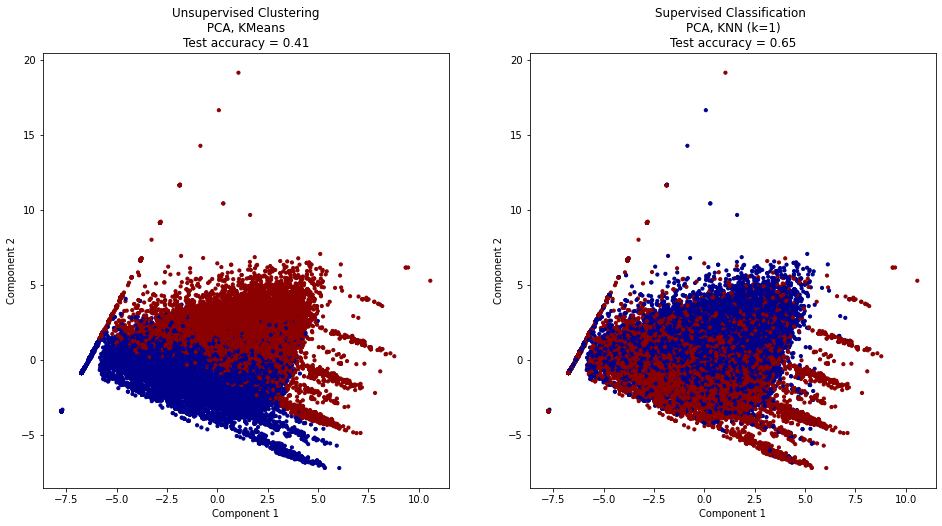

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=predicted_clusters, s=10, cmap=newcmp)
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title("Unsupervised Clustering\n {}, KMeans \nTest accuracy = {:.2f}".format("PCA", kmeans_acc))


ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=knn_predict, s=10, cmap=newcmp)
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title("Supervised Classification \n{}, KNN (k={})\nTest accuracy = {:.2f}".format("PCA", n_neighbors, acc_knn))


plt.show()


In [32]:
# knn 3 = 0.64
# knn 1 = 0.65

In [36]:
newcmp2 = ListedColormap(["gold", "darkblue"], name='YellowBlue')

Text(0.5, 1.0, 'Actual class separation in two dimensions')

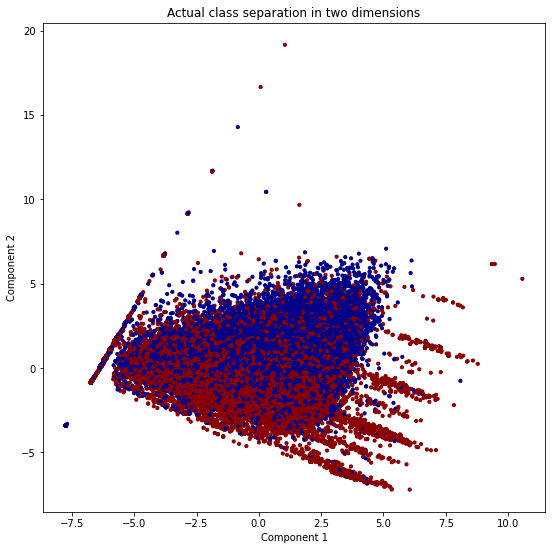

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, s=10, cmap=newcmp)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title("Actual class separation in two dimensions")